In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-22 04:09:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2025-02-22 04:09:17 (146 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [64]:
from datasets import load_dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

text = ''.join(dataset['train']['text']) + ''.join(dataset['validation']['text']) 

KeyError: 'tags'

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Assuming your notebook's working directory is set such that ../llm-tokenizer is reachable:
tokenizer_dir = os.path.abspath(os.path.join(os.getcwd(), '../llm-tokenizer'))
if tokenizer_dir not in sys.path:
    sys.path.insert(0, tokenizer_dir)

import BPETokenizer  # Now you should be able to import it

In [1]:
import torch
import torch.nn.functional as F
from random import random

device = 'cuda' if torch.cuda.is_available else 'cpu'

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    device_props = torch.cuda.get_device_properties(current_device)
    memory_summary = torch.cuda.memory_summary(device=current_device, abbreviated=True)
    
    print("Current device index:", current_device)
    print("Running on GPU:", device_name)
    print("GPU properties:")
    print("  - Compute Capability:", f"{device_props.major}.{device_props.minor}")
    print("  - Total Memory:", f"{device_props.total_memory / (1024**3):.2f} GB")
    print("  - Multiprocessor Count:", device_props.multi_processor_count)
    print("  - Max Threads per Multiprocessor:", device_props.max_threads_per_multi_processor)
else:
    print("CUDA is not available, running on CPU.")

Current device index: 0
Running on GPU: NVIDIA RTX A6000
GPU properties:
  - Compute Capability: 8.6
  - Total Memory: 47.54 GB
  - Multiprocessor Count: 84
  - Max Threads per Multiprocessor: 1536


# Pretraining Data - GPT Data Loader

In [3]:
class DataLoader:
    """next token prediction DataLoader used for GPT like models"""
    def __init__(self, config):
        
        self.config = config

        with open('input.txt', 'r') as f:
            text = f.read()
        len(text)

        self.tokenizer = BPETokenizer.Tokenizer(text, encoding_vocab_size=2000, raw_tokens=False)
        self.tokenizer.load_from_file()
        encoded_dataset = self.tokenizer.encode(text, raw_tokens=False)
        print(f"max vocabulary size={max(encoded_dataset)}, compression ratio={len(encoded_dataset) / len(text)}")
        split = int(len(encoded_dataset) * 0.80)
        self.train_data =  torch.tensor(encoded_dataset[:split])
        self.val_data = torch.tensor(encoded_dataset[split+config.block_size:])
        print(f"train_data.shape={self.train_data.shape}, val_data.shape={self.val_data.shape}")
        
        self.train_data_ix = 0
        self.val_data_ix = 0
        self.batch_step = self.config.batch_size * self.config.block_size 
        
    def next_batch(self, mode="train", device=device):
        """ mode=["train", "eval"] """
        if mode == "train":
            x, y = self._next_batch_train()
        else:
            x, y = self._next_batch_eval()
        if device:
            return x.to(device), y.to(device)
        return x, y
    
    def _next_batch_train(self):
        
        data = self.train_data
        ix = int(random() * (len(data) - 2*self.batch_step))
        
        buf = data[ix:ix+self.batch_step + 1]     
        x = buf[:-1].view(self.config.batch_size, self.config.block_size)
        y = buf[1:].view(self.config.batch_size, self.config.block_size)
        
        self.train_data_ix += self.batch_step 
        if self.train_data_ix + self.batch_step + 1 > len(self.train_data):
            self.train_data_ix = 0
        
        return x, y
    
    def _next_batch_eval(self):
        
        data = self.val_data
        ix = int(random() * (len(data) - 2*self.batch_step))
        
        buf = data[ix:ix+self.batch_step + 1]     
        x = buf[:-1].view(self.config.batch_size, self.config.block_size)
        y = buf[1:].view(self.config.batch_size, self.config.block_size)
        
        self.val_data_ix += self.batch_step 
        if self.val_data_ix + self.batch_step + 1 > len(self.val_data):
            self.val_data_ix = 0
        
        return x, y

In [4]:
from dataclasses import dataclass

@dataclass
class BERTConfig:
    BERT_batch_size = 6
    batch_size = BERT_batch_size * 2
    block_size = 5
    
config = BERTConfig

In [5]:
data_loader = DataLoader(config)
x, y = data_loader.next_batch(device=None, mode="eval")

max vocabulary size=2213, compression ratio=0.4458684554516162
train_data.shape=torch.Size([397855]), val_data.shape=torch.Size([99459])


In [6]:
x.shape, y.shape

(torch.Size([12, 5]), torch.Size([12, 5]))

# Pretraining Data - BERT Data Loader

In [7]:
class BERTDataLoader(DataLoader):
    """data loader for BERT-like MLM + NSP loss"""
    def __init__(self, config):
        super().__init__(config)
        self.max_vocab_size = max(self.tokenizer.encoding_map.values())
        self.CLS =self.max_vocab_size + 1
        self.SEP = self.CLS + 1
        self.MASK = self.SEP + 1
        print(f"new tokens: {self.max_vocab_size}, {self.CLS}, {self.SEP}, {self.MASK}")
        
    def next_batch(self, device=device, test=False, mode="train"):
        """return x, y for Masked Language Model (MLM), MLM loss mask, y for Next Sentence Prediction"""
        _x, _ = super().next_batch(device=None, mode=mode)
        x, y_MLM, ix_MLM, y_NSP = [], [], [], []
        assert len(_x) % 2 == 0, "BERTDataLoader batch size should be % 2 == 0"
        for ix in range(int(len(_x) / 2)): 
            x0 = _x[ix].clone()
            if random() < 0.5:
                x1 = _x[ix+1].clone()
                y_NSP.append(torch.tensor(1))
            else:
                __x, _ = super().next_batch(device=None)
                x1 = __x[0].clone()
                y_NSP.append(torch.tensor(0))
            y_MLM.append(self._make_input(x0, x1))
            x0, ix0 = self._mask(x0)
            x1, ix1 = self._mask(x1)
            x.append(self._make_input(x0, x1))
            ix_MLM.append(torch.cat([
                torch.tensor([0]), 
                ix0,
                torch.tensor([0]), 
                ix1,
                torch.tensor([0])
                ]))
            
        if test:
            for i, xx in enumerate(x):
                if y_NSP[i] == 1:
                    a, b = y_MLM[i][1:1+BERTConfig.block_size], _x[i]
                    assert (a == b).all(), (a, b)
                    a, b = y_MLM[i][1+BERTConfig.block_size+1:1+2*BERTConfig.block_size+1], _x[i+1]
                    assert (a == b).all(), (a, b)
                    print(f"{i} TEST PASSED same sentence")
                    
        # turn indexes of MLM into a average loss mask
        ix_MLM = torch.stack(ix_MLM).to(device)
        ix_MLM = (ix_MLM / ix_MLM.sum()).nan_to_num(0.0)
            
        return (
            torch.stack(x).to(device), 
            torch.stack(y_MLM).to(device), 
            ix_MLM, 
            torch.stack(y_NSP).to(device)
        )
    
    def _make_input(self, x0, x1):
        return torch.cat([
            torch.tensor([self.CLS]), 
            x0,
            torch.tensor([self.SEP]), 
            x1,
            torch.tensor([self.SEP])
        ])
    
    def _mask(self, x):
        ix = []
        for i, v in enumerate(x):
            if random() < 0.15:
                ix.append(torch.tensor(1))
                r2 = random()
                if r2 < 0.80:
                    x[i] = self.MASK
                elif 0.80 <= r2 < 0.90:
                    x[i] = int(random() * (self.max_vocab_size - 100))
            else: ix.append(torch.tensor(0))
        return x, torch.tensor(ix)

In [8]:
data_loader = BERTDataLoader(config)

max vocabulary size=2213, compression ratio=0.4458684554516162
train_data.shape=torch.Size([397855]), val_data.shape=torch.Size([99459])
new tokens: 2215, 2216, 2217, 2218


In [9]:
x, y_MLM, loss_mask_MLM, y_NSP = data_loader.next_batch(device=device, test=True, mode="eval")

1 TEST PASSED same sentence
2 TEST PASSED same sentence
4 TEST PASSED same sentence
5 TEST PASSED same sentence


# Model

In [2]:
from dataclasses import dataclass

@dataclass
class BERTConfig:
    # model is going to be (BERT_batch_size, input_size, embedding_size or hidden_layer_size)
    BERT_batch_size = 6
    batch_size = BERT_batch_size * 2
    block_size = 5
    embedding_size = 64
    vocab_size = 2220 # new tokens: 2215, 2216, 2217, 2218 from dataloader
    input_size = 2 * block_size + 3
    hidden_layer_size = 256
    attention_heads = 8
    attention_size = embedding_size // attention_heads
    
config = BERTConfig

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:


class InputRepresentation(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.embedding_size)
        self.segment_embeddings = nn.Embedding(2, config.embedding_size)
        self.position_embeddings = nn.Embedding(config.input_size + 1, config.embedding_size)
        self.register_buffer('segment_index', 
                             torch.tensor(sum([
                                 [0] * (config.block_size + 1), 
                                 [0], 
                                 [1] * (config.block_size + 1)], [])))
        self.register_buffer('position_index', 
                             torch.arange(config.input_size))
    
    def forward(self, x):
        token_embeddings = self.token_embeddings(x)
        segment_embeddings = self.segment_embeddings(self.segment_index)
        position_embeddings = self.position_embeddings(self.position_index)
        x = position_embeddings + token_embeddings + segment_embeddings
        return x

In [5]:
input_embeddings = InputRepresentation(config)
input_embeddings.to(device)

InputRepresentation(
  (token_embeddings): Embedding(2220, 64)
  (segment_embeddings): Embedding(2, 64)
  (position_embeddings): Embedding(14, 64)
)

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.key = nn.Linear(config.embedding_size, config.attention_size)
        self.query = nn.Linear(config.embedding_size, config.attention_size)
        self.value = nn.Linear(config.embedding_size, config.attention_size)
        
    def forward(self, x):
        key = self.key(x)
        query = self.query(x)
        attention = F.softmax(key @ query.transpose(1, 2), dim=2)
        value = self.value(x)
        return attention @ value
    
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(config) for _ in range(config.attention_heads)])
        self.linear = nn.Linear(config.embedding_size, config.embedding_size)
        
    def forward(self, x):
        heads = []
        for head in self.heads:
            heads.append(head(x))
        x = torch.cat(heads, dim=2)
        x = self.linear(x)
        return x

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.mlp = nn.ModuleList([
            nn.LayerNorm(config.embedding_size),
            nn.Linear(config.embedding_size, config.hidden_layer_size),
            nn.ReLU(),
            nn.Linear(config.hidden_layer_size, config.embedding_size)
        ])
        self.attention_norm = nn.LayerNorm(config.embedding_size)
        
    def forward(self, x):
        x = x + self.attention(self.attention_norm(x))
        mlp = self.mlp[0](x)
        for layer in self.mlp[1:]:
            mlp = layer(mlp)
        return x + mlp

In [8]:
attention = SelfAttention(config)

attention = MultiHeadAttention(config)

transformer = TransformerBlock(config)

In [9]:
class BERT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.input_representation = InputRepresentation(config)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config.transformer_blocks)])
        
        self.MLM_output = nn.Linear(config.embedding_size, config.vocab_size)
        self.NSP_output = nn.Linear(config.embedding_size, 1)
        
    def forward(self, x, y_NSP=None, y_MLM=None, loss_mask_MLM=None):
        """return (pred_NSP, logits_MSM, loss_NSP, loss_MLM)"""
        x = self.input_representation(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        
        pred_NSP = F.sigmoid(self.NSP_output(x[:, 0, :]))
        logits_MSM = self.MLM_output(x)
        
        loss_NSP, loss_MLM = None, None
        if y_NSP is not None:
            loss_NSP = F.binary_cross_entropy(pred_NSP.view(-1), y_NSP.to(torch.float))
            
        if y_MLM is not None and loss_mask_MLM is not None:
            loss_MLM = F.cross_entropy(
                logits_MSM.reshape(config.BERT_batch_size * config.input_size, -1), 
                y_MLM.reshape(-1),
                reduction='none')
            loss_MLM = (loss_MLM * loss_mask_MLM.view(-1)).sum()
        
        
        return pred_NSP, logits_MSM, loss_NSP, loss_MLM

In [18]:
BERT(config)

AttributeError: type object 'BERTConfig' has no attribute 'transformer_blocks'

# Pretraining

In [10]:
class LossLogs:
    def __init__(self, name, scale=1):
        self.train_x, self.val_x = [], []
        self.train_loss, self.val_loss = [], []
        self.val_loss_bags = {}
        self.name = name
        self.scale = scale
    
    def log_train(self, ix, loss):
        self.train_x.append(ix)
        self.train_loss.append(loss)
        
    def log_val(self, train_ix, val_ix, loss):
        if train_ix in self.val_loss_bags.keys():
            self.val_loss_bags[train_ix].append(loss)
        else:
            self.val_loss_bags[train_ix] = [loss]
        
    def get_val_loss(self, train_ix):
        self.val_x.append(train_ix)
        val_loss = sum(self.val_loss_bags[train_ix]) / len(self.val_loss_bags[train_ix])
        self.val_loss.append(val_loss)
        return val_loss
    
    def train_loss_series(self, aggr=100):
        ixs, xs, aggcum = [], [], 0
        for ix in range(len(self.train_x)):
            aggcum += self.train_loss[ix]
            if (ix + 1) % aggr == 0:
                xs.append((aggcum/aggr)*self.scale)
                aggcum = 0
                ixs.append(ix)
        return ixs, xs
    
    def val_loss_series(self):
        return self.val_x, [self.scale * x for x in self.val_loss]
    
    def state_dict(self):
        # Return a shallow copy of all instance attributes.
        return self.__dict__.copy()

    def load_state_dict(self, state):
        # Update the instance attributes with those saved in the checkpoint.
        self.__dict__.update(state)


In [11]:
!nvidia-smi

Sun Feb 23 03:28:29 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   38C    P2    75W / 300W |    853MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
from dataclasses import dataclass, field
import uuid

@dataclass
class BERTConfig:
    # model is going to be (BERT_batch_size, input_size, embedding_size or hidden_layer_size)
    BERT_batch_size = 64
    batch_size = BERT_batch_size * 2
    block_size = 40
    embedding_size = 256*2
    vocab_size = 2220 # new tokens: 2215, 2216, 2217, 2218 from dataloader
    input_size = 2 * block_size + 3
    hidden_layer_size = 1024
    attention_heads = 8
    attention_size = embedding_size // attention_heads
    train_epochs = 10000
    val_epochs = 30
    val_interval = 100
    transformer_blocks = 10
    model_name: str = field(default_factory=lambda: f"BERT_{uuid.uuid4()}")
    
config = BERTConfig()

In [13]:
config.model_name

'BERT_f6559a6a-7423-41a2-8444-0acf86a52c7a'

In [14]:
model = BERT(config)

print(sum(p.numel() for p in model.parameters()))
model.to(device)

MLMloss = LossLogs("MLM", scale=0.1)
NSPloss = LossLogs("NSP")
data_loader = BERTDataLoader(config)

23347885


NameError: name 'BERTDataLoader' is not defined

In [15]:
#prev_train_epoch = train_epoch
prev_train_epoch = 0
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [55]:
for train_epoch in range(config.train_epochs):
    
    train_epoch += prev_train_epoch
    
    optimizer.zero_grad()
    
    x, y_MLM, loss_mask_MLM, y_NSP = data_loader.next_batch(device=device)
    pred_NSP, logits_MSM, loss_NSP, loss_MLM = model(x, y_NSP=y_NSP, y_MLM=y_MLM, loss_mask_MLM=loss_mask_MLM)
    loss = loss_NSP + loss_MLM
    loss.backward()
    optimizer.step()
    MLMloss.log_train(train_epoch, loss_MLM.item())
    NSPloss.log_train(train_epoch, loss_NSP.item())
    
    if train_epoch % config.val_interval == 0:
        
        with torch.no_grad():
            model.eval()
            for val_epoch in range(config.val_epochs):
                x, y_MLM, loss_mask_MLM, y_NSP = data_loader.next_batch(device=device, mode="eval")
                pred_NSP, logits_MSM, loss_NSP, loss_MLM = model(x, y_NSP=y_NSP, y_MLM=y_MLM, loss_mask_MLM=loss_mask_MLM)
                MLMloss.log_val(train_epoch, val_epoch, loss_MLM.item())
                NSPloss.log_val(train_epoch, val_epoch, loss_NSP.item())
            model.train()
        
        
        log_string = f"[{train_epoch}/{config.train_epochs}]"
        log_string += f"[MLM losses: train={loss_MLM.item():.3f},val={MLMloss.get_val_loss(train_epoch):.3f}]"
        log_string += f"[NSP losses: train={loss_NSP.item():.3f},val={NSPloss.get_val_loss(train_epoch):.3f}]"
        print(log_string)
    
# 1 attention only [4500/10000][MLM losses: train=6.047,val=5.977][NSP losses: train=0.708,val=0.690]
# 1 attention + 1 MLP [4500/10000][MLM losses: train=6.124,val=5.418][NSP losses: train=0.687,val=0.695]
# 1 block @2M params [3000/10000][MLM losses: train=3.718,val=3.398][NSP losses: train=0.688,val=0.695]
# 4 blocks @4M params [3000/10000][MLM losses: train=2.516,val=2.724][NSP losses: train=0.645,val=0.667]
# 8 blocks @20M params [5500/10000][MLM losses: train=2.562,val=2.664][NSP losses: train=0.478,val=0.485]

[0/10000][MLM losses: train=8.167,val=8.158][NSP losses: train=4.324,val=3.682]
[100/10000][MLM losses: train=5.950,val=6.024][NSP losses: train=0.717,val=0.740]
[200/10000][MLM losses: train=5.896,val=5.856][NSP losses: train=0.700,val=0.696]


KeyboardInterrupt: 

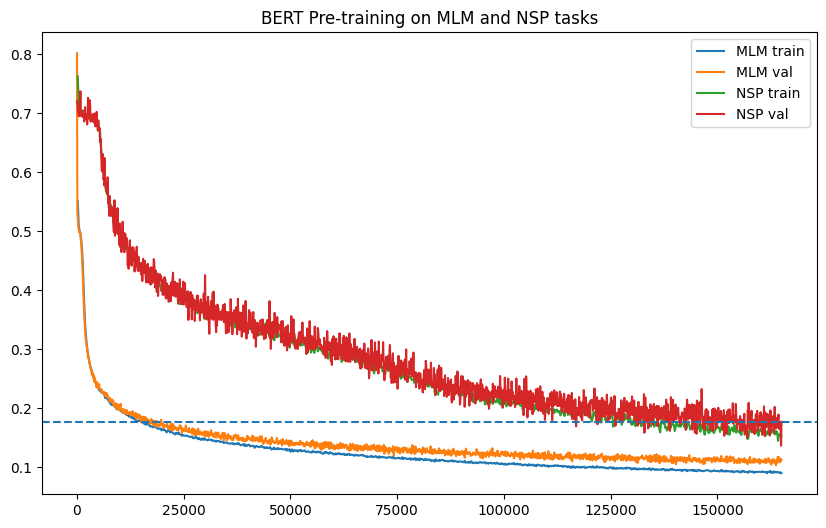

In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(*MLMloss.train_loss_series(aggr=200), label="MLM train")
plt.plot(*MLMloss.val_loss_series(), label="MLM val")
plt.plot(*NSPloss.train_loss_series(aggr=200), label="NSP train")
plt.plot(*NSPloss.val_loss_series(), label="NSP val")
plt.legend()
plt.title("BERT Pre-training on MLM and NSP tasks")
plt.axhline(NSPloss.val_loss[-1], linestyle="--")
plt.show()


In [364]:
NSPloss.train_loss[1] = 4

In [368]:
NSPloss.train_loss = NSPloss.train_loss[20:]

In [370]:
NSPloss.train_loss = ([0.8] * 20) + NSPloss.train_loss

# Checkpoint

In [17]:
import torch

def save_checkpoint(model, optimizer, train_epoch, MLMloss, NSPloss, model_name):
    checkpoint_path = f"checkpoint_latest_{model_name}.pth"
    checkpoint = {
        'train_epoch': train_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'MLMloss_state': MLMloss.state_dict(),
        'NSPloss_state': NSPloss.state_dict(),
        'model_name': model_name
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")
    return checkpoint_path

def load_checkpoint(model, optimizer, checkpoint_path, MLMloss, NSPloss):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_epoch = checkpoint['train_epoch']
    MLMloss.load_state_dict(checkpoint['MLMloss_state'])
    NSPloss.load_state_dict(checkpoint['NSPloss_state'])
    model_name = checkpoint['model_name']
    print(f"Checkpoint loaded from {checkpoint_path}, resuming at epoch {train_epoch}")
    return train_epoch, model_name


#checkpoint_path = save_checkpoint(model, optimizer, train_epoch, MLMloss, NSPloss, config.model_name)

#train_epoch, model_name = load_checkpoint(model, optimizer, checkpoint_path, MLMloss, NSPloss)

In [40]:
MLMloss.train_loss_series()

([], [])

In [18]:
train_epoch, model_name = load_checkpoint(model, optimizer, "BERT_checkpoints/checkpoint_BERT_wikitext2_6hours.pth", MLMloss, NSPloss)

Checkpoint loaded from BERT_checkpoints/checkpoint_BERT_wikitext2_6hours.pth, resuming at epoch 165000


In [26]:
v = MLMloss.val_loss

In [30]:
MLMloss.val_loss = v

In [28]:
MLMloss.val_loss = 50 * [1.0 ]+ MLMloss.val_loss[50:]

In [33]:
NSPloss.val_loss[0] = 0.72

In [42]:
MLMloss.val_loss[-10:]

[1.1686409910519917,
 1.1441652953624726,
 1.100809512535731,
 1.166192396481832,
 1.1278633972009022,
 1.077409601211548,
 1.1308937986691794,
 1.0933090627193451,
 1.1261402547359467,
 1.1264266490936279]

In [44]:
NSPloss.val_loss[-1]

0.17656663432717323